In [409]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

%matplotlib inline

In [5]:
df = pd.read_csv('data.csv')

In [6]:
df

,Tenv,Trad,U,I,BIT_code
0,18.286251,35.962047,24.000000,5.455493,0
1,20.098988,36.868416,24.000000,5.455493,0
2,19.604881,36.983831,23.955141,5.445296,0
3,19.044917,37.074179,24.420295,5.551031,0
4,18.475710,36.889644,24.000000,5.455493,0
...,...,...,...,...,...
999995,19.967467,38.862022,24.000000,5.931080,0
999996,18.613301,38.734617,24.000000,5.931080,0
999997,18.984941,38.661814,24.000000,5.931080,0
999998,17.876563,38.581711,24.000000,5.931080,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Tenv      1000000 non-null  float64
 1   Trad      1000000 non-null  float64
 2   U         1000000 non-null  float64
 3   I         1000000 non-null  float64
 4   BIT_code  1000000 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 38.1 MB


In [28]:
df.describe()

,Tenv,Trad,U,I,BIT_code
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,18.205488,41.685964,23.911695,7.288491,0.123360
std,2.951017,13.544227,1.242253,4.378547,0.370735
min,12.103546,12.715909,0.000000,0.000000,0.000000
25%,15.791192,33.748315,24.000000,4.770680,0.000000
50%,18.105321,39.574373,24.000000,6.344151,0.000000
75%,20.446811,49.177387,24.000000,9.536132,0.000000
max,25.953715,85.184644,25.199990,20.813207,4.000000


## Explore the data

In [29]:
df.BIT_code.unique()

array([0, 1, 4, 2, 3])

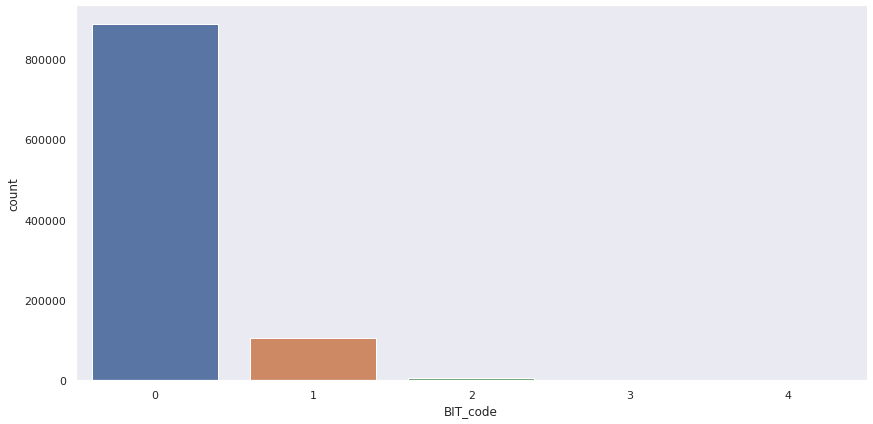

In [69]:
g = sns.catplot('BIT_code', data=df, kind='count', height=6, aspect=2)

Highly imbalanced data

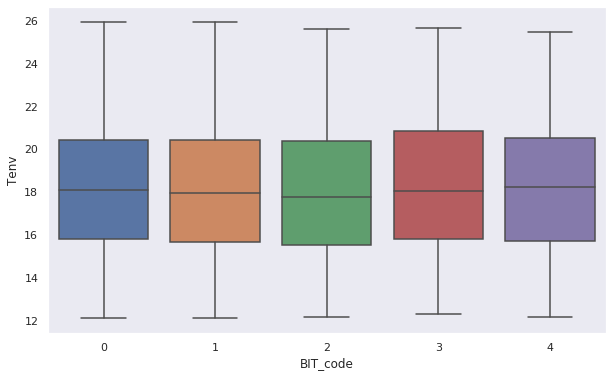

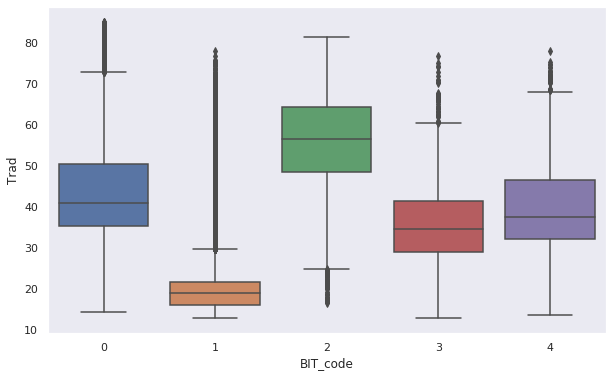

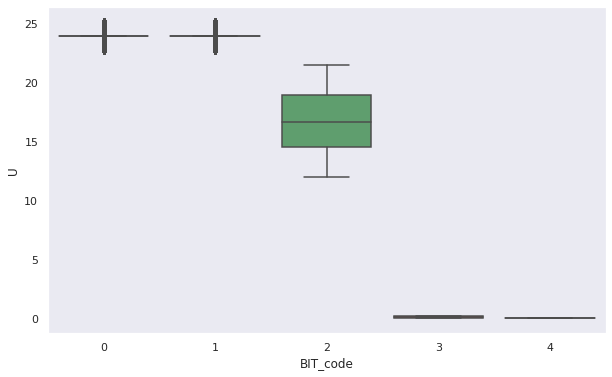

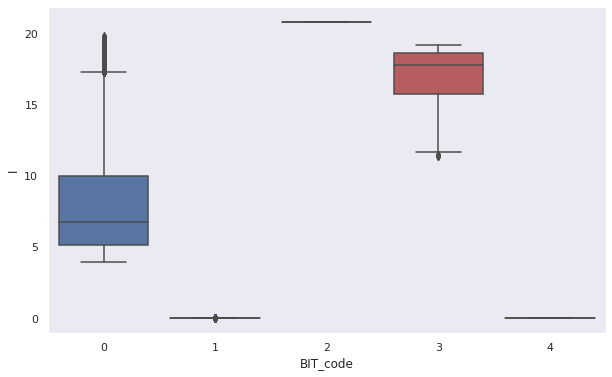

In [408]:
for c in df.columns[:-1]:
    _ = plt.figure(figsize=(10, 6))
    sns.boxplot(x='BIT_code', y=c, data=df)
    plt.show()

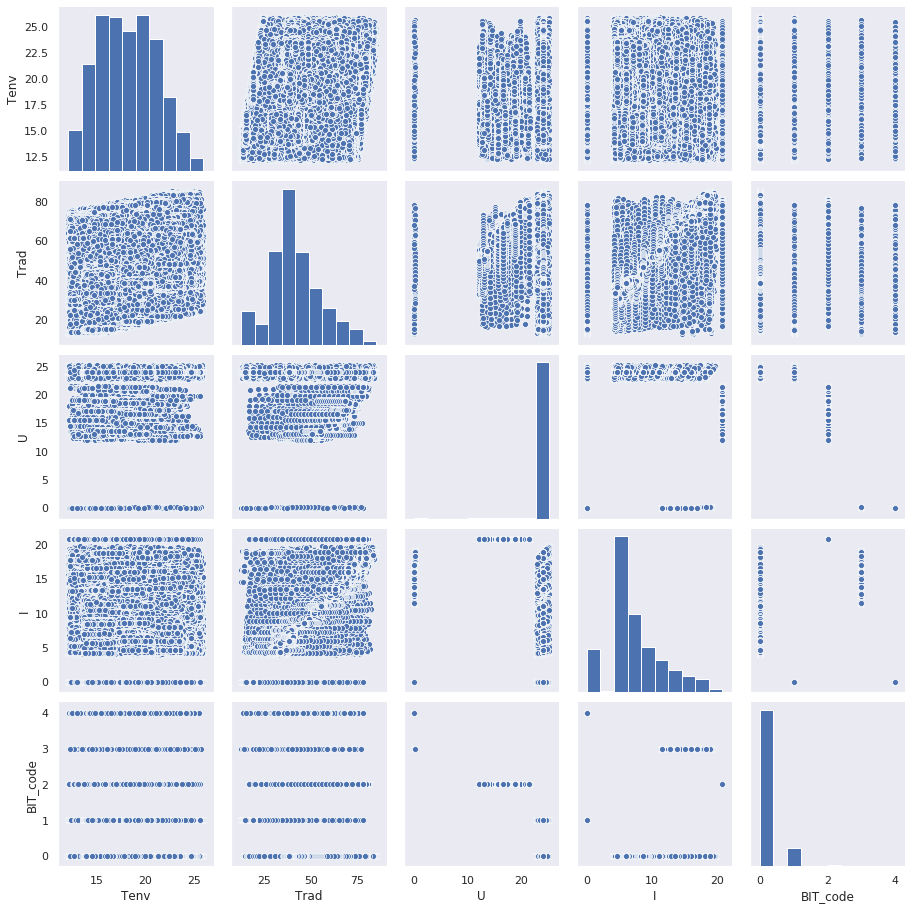

In [158]:
sns.pairplot(df)

U and I distributions related to BIT_code are discrimative and can imply rule-based approach

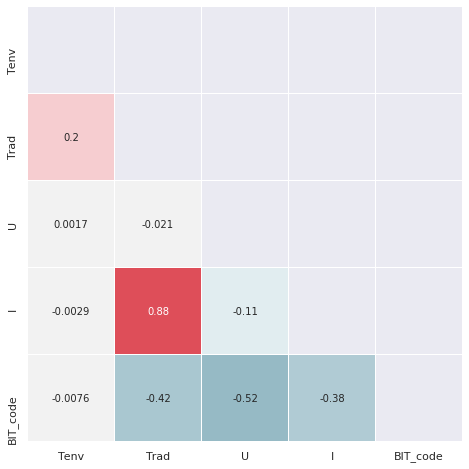

In [168]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.4, cbar=None, annot=True)
plt.show()

## Classification

In [297]:
def plot_cm(clf, X, y, labels=[0, 1, 2, 3, 4]):
    f, ax = plt.subplots(figsize=(7, 7))
    plot_confusion_matrix(clf, X, y, values_format='d', 
                          cmap=plt.cm.Blues, display_labels=labels, ax=ax)
    plt.title('Confusion matrix')
    plt.show()

In [349]:
X, y = df.drop(columns=['BIT_code']), df.BIT_code

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    random_state=32, stratify=y)

In [351]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Rule-based approach

Based on pairplots lets try to set some rules to classify power supply faults

In [392]:
def predict_code(row): 
    if row[3] < 1 and row[2] < 1:
        return 4
    elif row[2] < 1 and row[3] > 5:
        return 3
    elif row[3] < 1:
        return 1
    elif row[3] > 20:
        return 2
    else: 
        return 0

def predict_by_rules(X):
    ans = []
    for row in X:
        ans.append(predict_code(row))
    return ans

In [394]:
print(f'Number of the incorrect predictions: {sum(predict_by_rules(np.array(X)) != y)}')

Number of the incorrect predictions: 0


We don't need Tenv and Trad at all in this case

### 1. Logistic Regression Classification

In [240]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [242]:
logreg_pred = logreg.predict(X_test)

classification report

In [245]:
print(classification_report(y_test, logreg_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    292816
           1       1.00      1.00      1.00     34640
           2       1.00      1.00      1.00      1894
           3       1.00      1.00      1.00       320
           4       1.00      1.00      1.00       330

    accuracy                           1.00    330000
   macro avg       1.00      1.00      1.00    330000
weighted avg       1.00      1.00      1.00    330000



confusion matrix

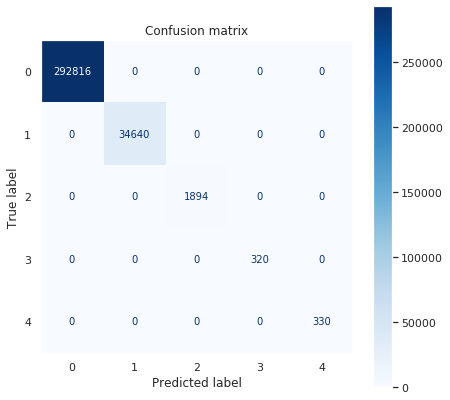

In [298]:
plot_cm(logreg, X_test, y_test)

feature importances

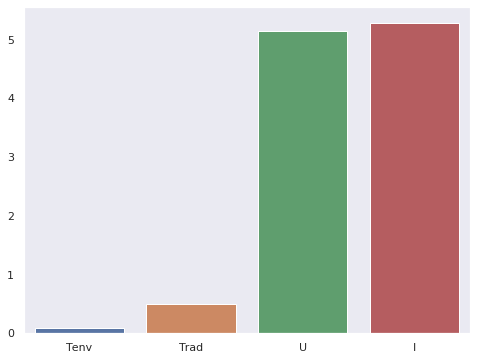

In [301]:
plt.figure(figsize=(8, 6))
sns.barplot(x=X.columns, y=logreg.coef_[0])
plt.show()

### 2. Decision Trees Classification

In [305]:
dtrees = DecisionTreeClassifier()
dtrees.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [306]:
dtrees_pred = dtrees.predict(X_test)

classification report

In [307]:
print(classification_report(y_test, dtrees_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    292816
           1       1.00      1.00      1.00     34640
           2       1.00      1.00      1.00      1894
           3       1.00      1.00      1.00       320
           4       1.00      1.00      1.00       330

    accuracy                           1.00    330000
   macro avg       1.00      1.00      1.00    330000
weighted avg       1.00      1.00      1.00    330000



### 3. Ada Boost Classification

In [352]:
ada_boost = AdaBoostClassifier(n_estimators=100)
ada_boost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=None)

In [353]:
adaboost_pred = ada_boost.predict(X_test)

In [355]:
print(classification_report(y_test, adaboost_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    292816
           1       1.00      1.00      1.00     34640
           2       1.00      1.00      1.00      1894
           3       0.00      0.00      0.00       320
           4       1.00      1.00      1.00       330

    accuracy                           1.00    330000
   macro avg       0.80      0.80      0.80    330000
weighted avg       1.00      1.00      1.00    330000



confusion matrix

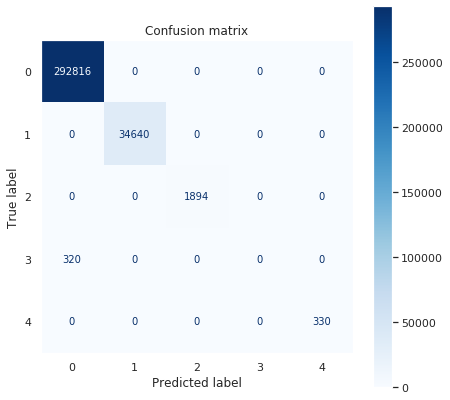

In [356]:
plot_cm(ada_boost, X_test, y_test)

feature importances

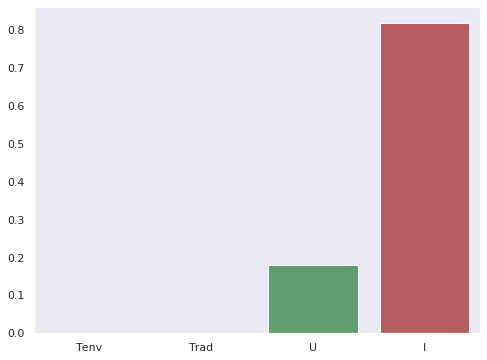

In [330]:
plt.figure(figsize=(8, 6))
sns.barplot(x=X.columns, y=ada_boost.feature_importances_)
plt.show()

### Random forest

In [312]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [315]:
rf_pred = rf.predict(X_test)

classification report

In [316]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    292816
           1       1.00      1.00      1.00     34640
           2       1.00      1.00      1.00      1894
           3       1.00      1.00      1.00       320
           4       1.00      1.00      1.00       330

    accuracy                           1.00    330000
   macro avg       1.00      1.00      1.00    330000
weighted avg       1.00      1.00      1.00    330000



feature importances

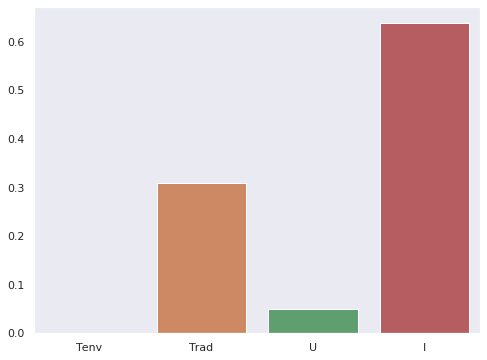

In [328]:
plt.figure(figsize=(8, 6))
sns.barplot(x=X.columns, y=rf.feature_importances_)
plt.show()

### SVM

In [333]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [334]:
svc_pred = svc.predict(X_test)

classification report

In [335]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    292816
           1       1.00      1.00      1.00     34640
           2       1.00      1.00      1.00      1894
           3       1.00      1.00      1.00       320
           4       1.00      1.00      1.00       330

    accuracy                           1.00    330000
   macro avg       1.00      1.00      1.00    330000
weighted avg       1.00      1.00      1.00    330000



feature importances

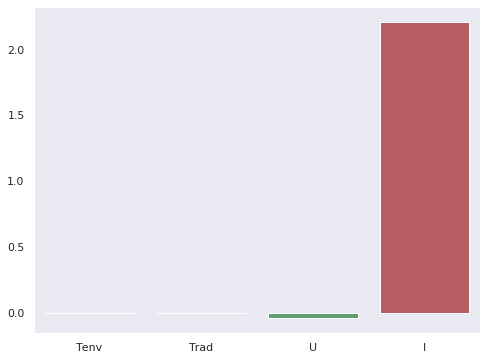

In [339]:
plt.figure(figsize=(8, 6))
sns.barplot(x=X.columns, y=svc.coef_[0])
plt.show()

### Summary
- With rule-based approach it's possible to correctly classify all instances
- The most important features are U, I.
- Linear models (Logistic Regression, SVM) are good options for this task
- Only Adaboost classifier have errors in faults classification